In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.fft as fft
import re
import os
import sys
import time
import scipy.signal as sgn
import plotly.graph_objects as go
import numpy as np
import plotly.express as px
import webbrowser

In [2]:
def esd(yt, fs):
    # computes ESD of a signal yt, keeping only positive frequencies! -> NOTE: this implies that total energy is halved
    N = len(yt)
    f = fft.rfftfreq(N, 1/fs)
    Sxx = np.square(1 / fs) *  np.square(np.abs(fft.rfft(yt)))
    
    return f, Sxx

In [3]:
dt = 0.005
fs_FTP = 10
k_subsample = int(1 / (dt * fs_FTP))

## Fixed $K_i=0.01$

In [4]:
KPs = []
KI = 0.01
KDs = []

pattern_file = r'PID_([\d\.]+)_([\d\.]+)_([\d\.]+).csv'
pattern_folder = r'KP=([\d\.]+)'

points = []

z = []

for folder in os.listdir('Kx_exploration_data'):
    match_folder = re.match(pattern_folder, folder)
    KP = float(match_folder.group(1))
    KPs.append(KP)
    
    same_KP = []

    for file in os.listdir(os.path.join('Kx_exploration_data', folder)):
        match_file = re.match(pattern_file, file)
        if float(match_file.group(2)) == KI:
            KD = float(match_file.group(3))
                        
            filename = 'Kx_exploration_data' + os.sep + folder + os.sep + file
            signals_df = pd.read_csv(filename, sep=',', header=0)
            x_t = np.array(signals_df['Time'], dtype=float)
            y_rv = np.array(signals_df['Velocity'], dtype=float)
            y_tv = np.array(signals_df['Target Velocity'], dtype=float)
            y_tp = np.array(signals_df['Throttle'], dtype=float)

            x_t = x_t[::k_subsample]
            y_rv = y_rv[::k_subsample]
            y_tv = y_tv[::k_subsample]
            y_tp = y_tp[::k_subsample]
            
            f, Sxx = esd(y_tp, fs_FTP)

            AggIn = float(np.mean(Sxx) / np.std(y_tv - y_rv))

            # append KD value to KDs list, if the element is not already present
            if KD not in KDs:
                KDs.append(KD)  
            
            same_KP.append(AggIn)
            
            points.append({'KP': KP, 'KI' : KI, 'KD': KD, 'AggIn' : AggIn})
        else:
            print("Skipped file: ", file)
    
    z.append(same_KP)


        

Skipped file:  PID_0.0494_0.001_0.01.csv
Skipped file:  PID_0.0494_0.0025_0.01.csv
Skipped file:  PID_0.0494_0.005_0.01.csv
Skipped file:  PID_0.0494_0.0075_0.01.csv
Skipped file:  PID_0.0494_0.02_0.01.csv
Skipped file:  PID_0.0494_0.03_0.01.csv
Skipped file:  PID_0.0494_0.04_0.01.csv
Skipped file:  PID_0.0494_0.05_0.01.csv
Skipped file:  PID_0.0494_0.06_0.01.csv
Skipped file:  PID_0.0494_0.07_0.01.csv
Skipped file:  PID_0.0494_0.08_0.01.csv
Skipped file:  PID_0.0494_0.09_0.01.csv
Skipped file:  PID_0.0494_0.125_0.01.csv
Skipped file:  PID_0.0494_0.15_0.01.csv
Skipped file:  PID_0.0494_0.1_0.01.csv
Skipped file:  PID_0.0494_0.225_0.01.csv
Skipped file:  PID_0.0494_0.25_0.01.csv
Skipped file:  PID_0.0494_0.2_0.01.csv
Skipped file:  PID_0.0494_0.3_0.01.csv
Skipped file:  PID_0.0494_0.4_0.01.csv
Skipped file:  PID_0.0494_0.5_0.01.csv
Skipped file:  PID_0.0494_0.6_0.01.csv
Skipped file:  PID_0.0494_0.8_0.01.csv
Skipped file:  PID_0.0494_0.9_0.01.csv
Skipped file:  PID_0.0494_1.0_0.01.csv
S

### Non-navigable plot

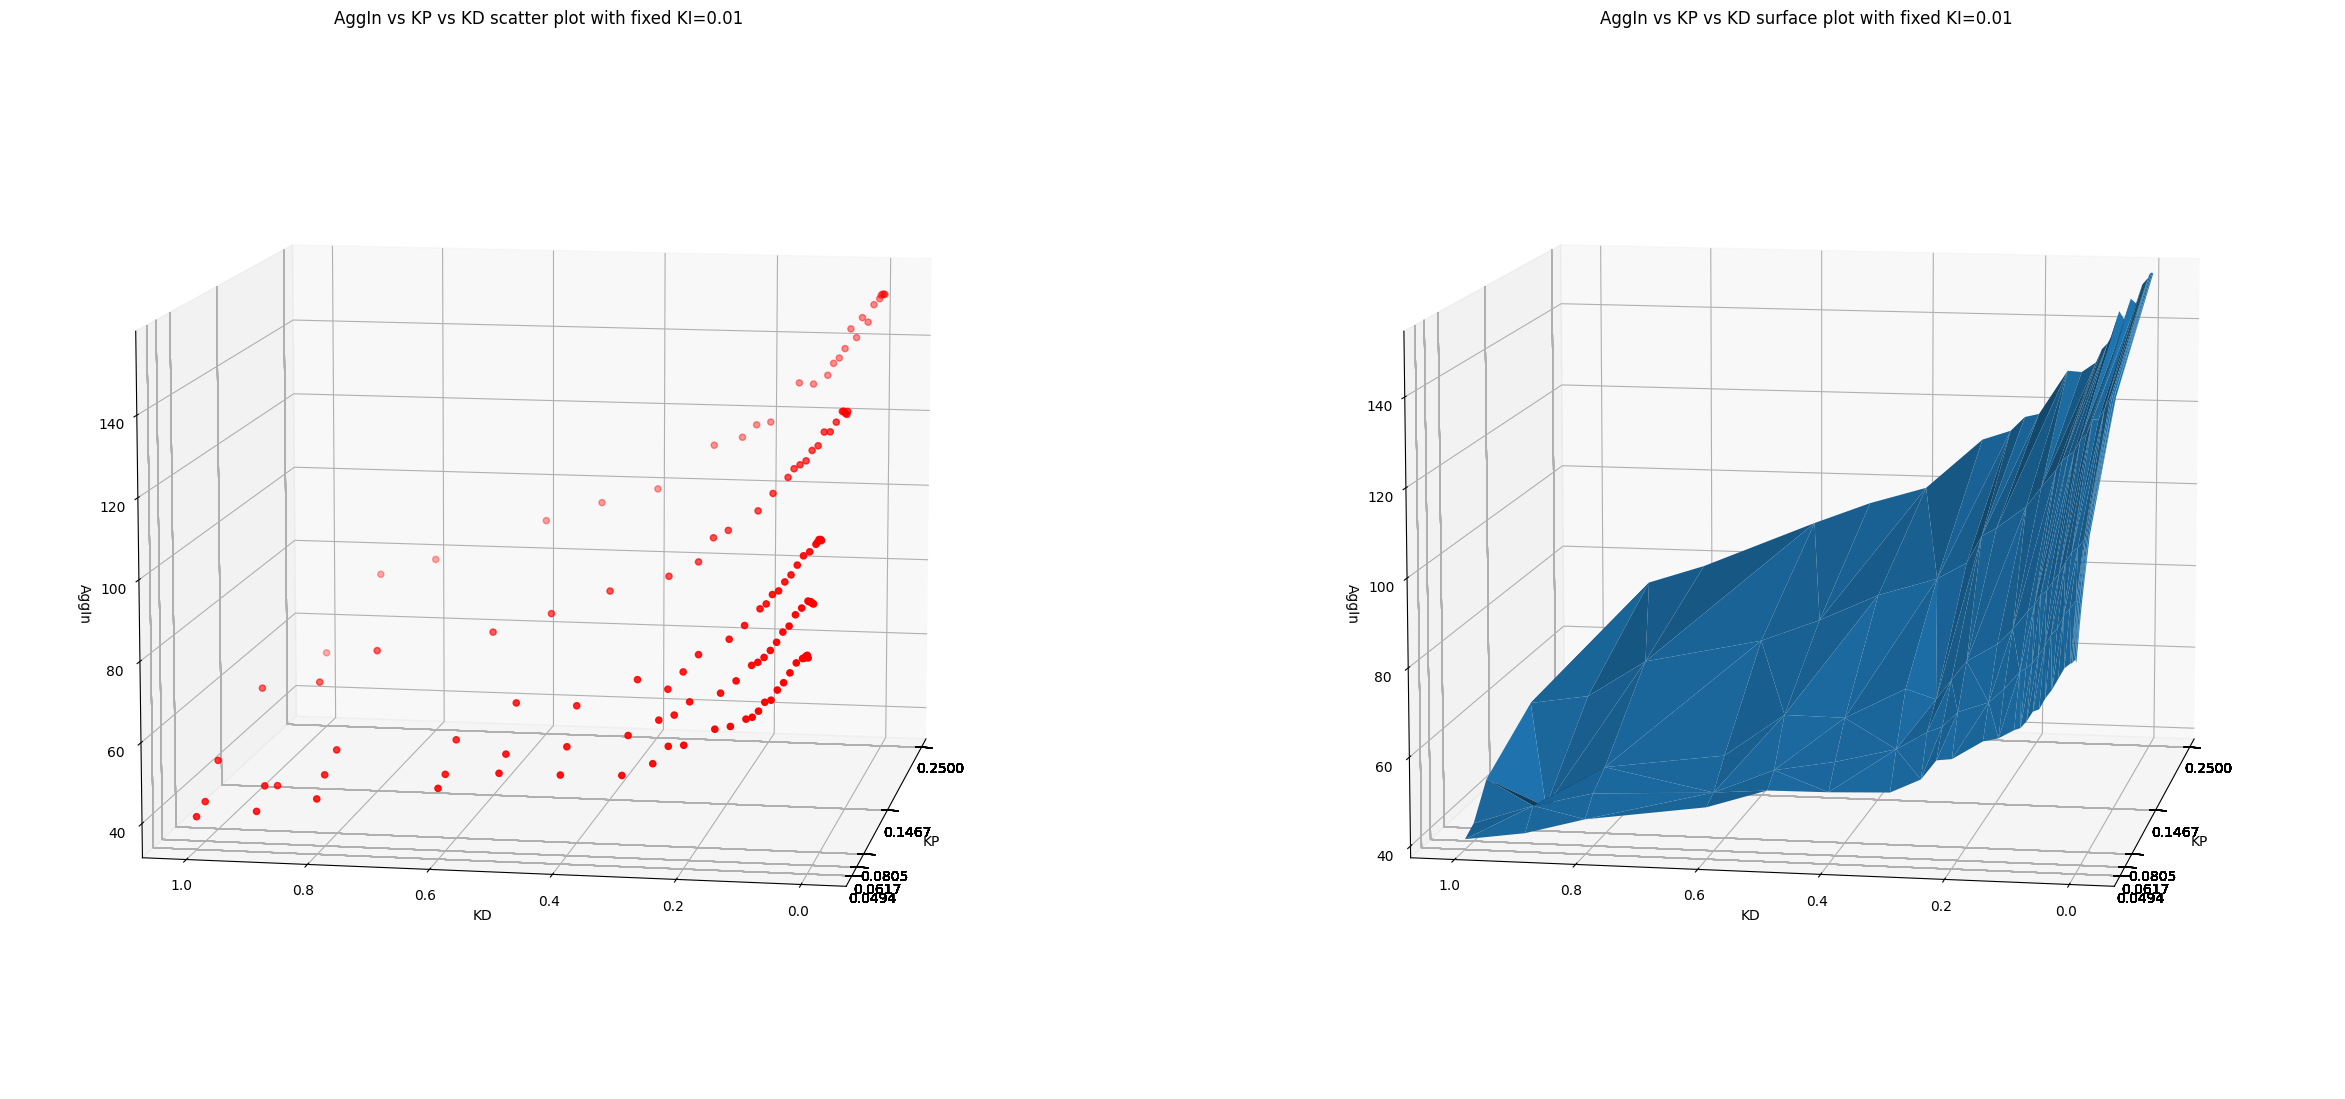

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw=dict(projection='3d'), figsize=(30, 15))
# set title to the first plot and plot the scatter plot
ax1.set_title("AggIn vs KP vs KD scatter plot with fixed KI=0.01")
ax1.scatter([d['KP'] for d in points], [d['KD'] for d in points], [d['AggIn'] for d in points], c='r', marker='o')
ax1.set_xlabel('KP')
# show only the lines corresponding to the values of KP. Ticks are shown, but not the labels
ax1.set_xticks([d['KP'] for d in points])
ax1.set_ylabel('KD')
ax1.set_zlabel('AggIn')
# rotate point of view of 180 degrees around the Z axis
ax1.view_init(azim=190, elev=10)

ax2.set_title("AggIn vs KP vs KD surface plot with fixed KI=0.01")
ax2.plot_trisurf([d['KP'] for d in points], [d['KD'] for d in points], [d['AggIn'] for d in points])
ax2.set_xticks([d['KP'] for d in points])
ax2.set_xlabel('KP')
ax2.set_ylabel('KD')
ax2.set_zlabel('AggIn')
ax2.view_init(azim=190, elev=10)
plt.show()

### Navigable 3D plot

In [6]:
plot_folder = 'Kx_exploration_plots'

##### Scatter plot

In [7]:
# Plot
fig = go.Figure(data=[go.Scatter3d(
    x=[d['KP'] for d in points ],
    y=[d['KD'] for d in points ],
    z=[d['AggIn'] for d in points],
    mode='markers',
    marker=dict(
        size=12,
        color=[d['AggIn'] for d in points],                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)])

fig.update_layout(  title = 'AggIn with fixed KI = 0.01',
                    scene=dict(xaxis_title='KP', yaxis_title='KD', zaxis_title='AggIn',))
fig.write_html(plot_folder + os.sep + 'AggIn_fixedKI_3Dscatter.html')

webbrowser.open(plot_folder + os.sep + 'AggIn_fixedKI_3Dscatter.html',new=2)

True

#### Surface plot

In [8]:
data = go.Surface(x = KDs, y = KPs, z = z)
fig = go.Figure(data = data)
fig.update_layout(  title = 'AggIn with fixed KI = 0.01',
                    scene=dict(xaxis_title='KD', yaxis_title='KP', zaxis_title='AggIn',))
fig.write_html(plot_folder + os.sep + 'AggIn_fixedKI_3Dsurface.html') 

webbrowser.open(plot_folder + os.sep + 'AggIn_fixedKI_3Dsurface.html',new=2)

True

## Fixed $K_i$ excluding points with big harmonics over a certain threshold

In [9]:
KPs = []
KI = 0.01
KDs = []

f_threshold = 0.8
k_threshold = 0.03

pattern_file = r'PID_([\d\.]+)_([\d\.]+)_([\d\.]+).csv'
pattern_folder = r'KP=([\d\.]+)'

points = []

z = []

for folder in os.listdir('Kx_exploration_data'):
    match_folder = re.match(pattern_folder, folder)
    KP = float(match_folder.group(1))    
    same_KP = []

    for file in os.listdir(os.path.join('Kx_exploration_data', folder)):
        match_file = re.match(pattern_file, file)
        if float(match_file.group(2)) == KI:
            KD = float(match_file.group(3))
                        
            filename = 'Kx_exploration_data' + os.sep + folder + os.sep + file
            signals_df = pd.read_csv(filename, sep=',', header=0)
            x_t = np.array(signals_df['Time'], dtype=float)
            y_rv = np.array(signals_df['Velocity'], dtype=float)
            y_tv = np.array(signals_df['Target Velocity'], dtype=float)
            y_tp = np.array(signals_df['Throttle'], dtype=float)

            x_t = x_t[::k_subsample]
            y_rv = y_rv[::k_subsample]
            y_tv = y_tv[::k_subsample]
            y_tp = y_tp[::k_subsample]
            
            f, Sxx = esd(y_tp, fs_FTP)

            AggIn = float(np.mean(Sxx) / np.std(y_tv - y_rv))

            # append KD and KP value to KDs or KPs list, if the element is not already present
            if KD not in KDs:
                KDs.append(KD)
            if KP not in KPs:
                KPs.append(KP)
  
            
            # append AggIn value to same_KP list only if the spectrum of throttle signal does not contain big harmonics
            # over a certain threshold 
            
            N = len(y_tv)
            yf = fft.rfft(y_tp)
            xf = fft.rfftfreq(N, 1/fs_FTP)
            
            flag = True
            for i in range(int(f_threshold / (fs_FTP / (2 * len(xf)))), len(xf)):
                if  np.abs(yf[i]) * 2 / N > k_threshold:
                    flag = False
                    break
            same_KP.append(AggIn)
            
            points.append({'KP': KP, 'KI' : KI, 'KD': KD, 'AggIn' : AggIn, 'Valid' : flag})
    
    z.append(same_KP)
        

### Navigable 3D plot

In [10]:
plot_folder = 'Kx_exploration_plots'

##### Scatter plot

In [11]:
# Plot
fig = go.Figure(data=[go.Scatter3d( x=[d['KP'] for d in points ],
                                    y=[d['KD'] for d in points ],
                                    z=[d['AggIn'] if d['Valid'] else None for d in points],
                                    mode='markers',
                                    name = 'valid',
                                    marker=dict(
                                        size=12,
                                        color=[d['AggIn'] for d in points],                # set color to an array/list of desired values
                                        colorscale='Viridis',   # choose a colorscale
                                        opacity= 0.8
                                    )),
                      go.Scatter3d( x=[d['KP'] for d in points ],
                                    y=[d['KD'] for d in points ],
                                    z=[d['AggIn'] if not d['Valid'] else None for d in points],
                                    mode='markers',
                                    name = 'invalid',
                                    marker=dict(
                                        size=12,
                                        color='red',                # set color to an array/list of desired values
                                        colorscale='Viridis',   # choose a colorscale
                                        opacity= 0.8
                                    ))
                      ])

fig.update_layout(  title = 'AggIn with fixed KI = 0.01 - invalidating harmonics over {} Hz with amplitude bigger than {}'.format(f_threshold, k_threshold),
                    scene=dict(xaxis_title='KP', yaxis_title='KD', zaxis_title='AggIn',))
fig.write_html(plot_folder + os.sep + 'AggIn_fixedKI_3Dscatter_noFastHarmonics.html')

webbrowser.open(plot_folder + os.sep + 'AggIn_fixedKI_3Dscatter_noFastHarmonics.html',new=2)

True

# Fixed $K_d=0.01$

In [12]:
KPs = []
KIs = []
KD = 0.01

pattern_file = r'PID_([\d\.]+)_([\d\.]+)_([\d\.]+).csv'
pattern_folder = r'KP=([\d\.]+)'

points = []

z = []

for folder in os.listdir('Kx_exploration_data'):
    match_folder = re.match(pattern_folder, folder)
    KP = float(match_folder.group(1))
    KPs.append(KP)
    
    same_KP = []

    for file in os.listdir(os.path.join('Kx_exploration_data', folder)):
        match_file = re.match(pattern_file, file)
        if float(match_file.group(3)) == KD:
            KI = float(match_file.group(2))
                        
            filename = 'Kx_exploration_data' + os.sep + folder + os.sep + file
            signals_df = pd.read_csv(filename, sep=',', header=0)
            x_t = np.array(signals_df['Time'], dtype=float)
            y_rv = np.array(signals_df['Velocity'], dtype=float)
            y_tv = np.array(signals_df['Target Velocity'], dtype=float)
            y_tp = np.array(signals_df['Throttle'], dtype=float)

            x_t = x_t[::k_subsample]
            y_rv = y_rv[::k_subsample]
            y_tv = y_tv[::k_subsample]
            y_tp = y_tp[::k_subsample]
            
            f, Sxx = esd(y_tp, fs_FTP)

            AggIn = float(np.mean(Sxx) / np.std(y_tv - y_rv))

            # append KD value to KDs list, if the element is not already present
            if KI not in KIs:
                KIs.append(KI)  
            
            same_KP.append(AggIn)
            
            points.append({'KP': KP, 'KI' : KI, 'KD': KD, 'AggIn' : AggIn})
    
    z.append(same_KP)


        

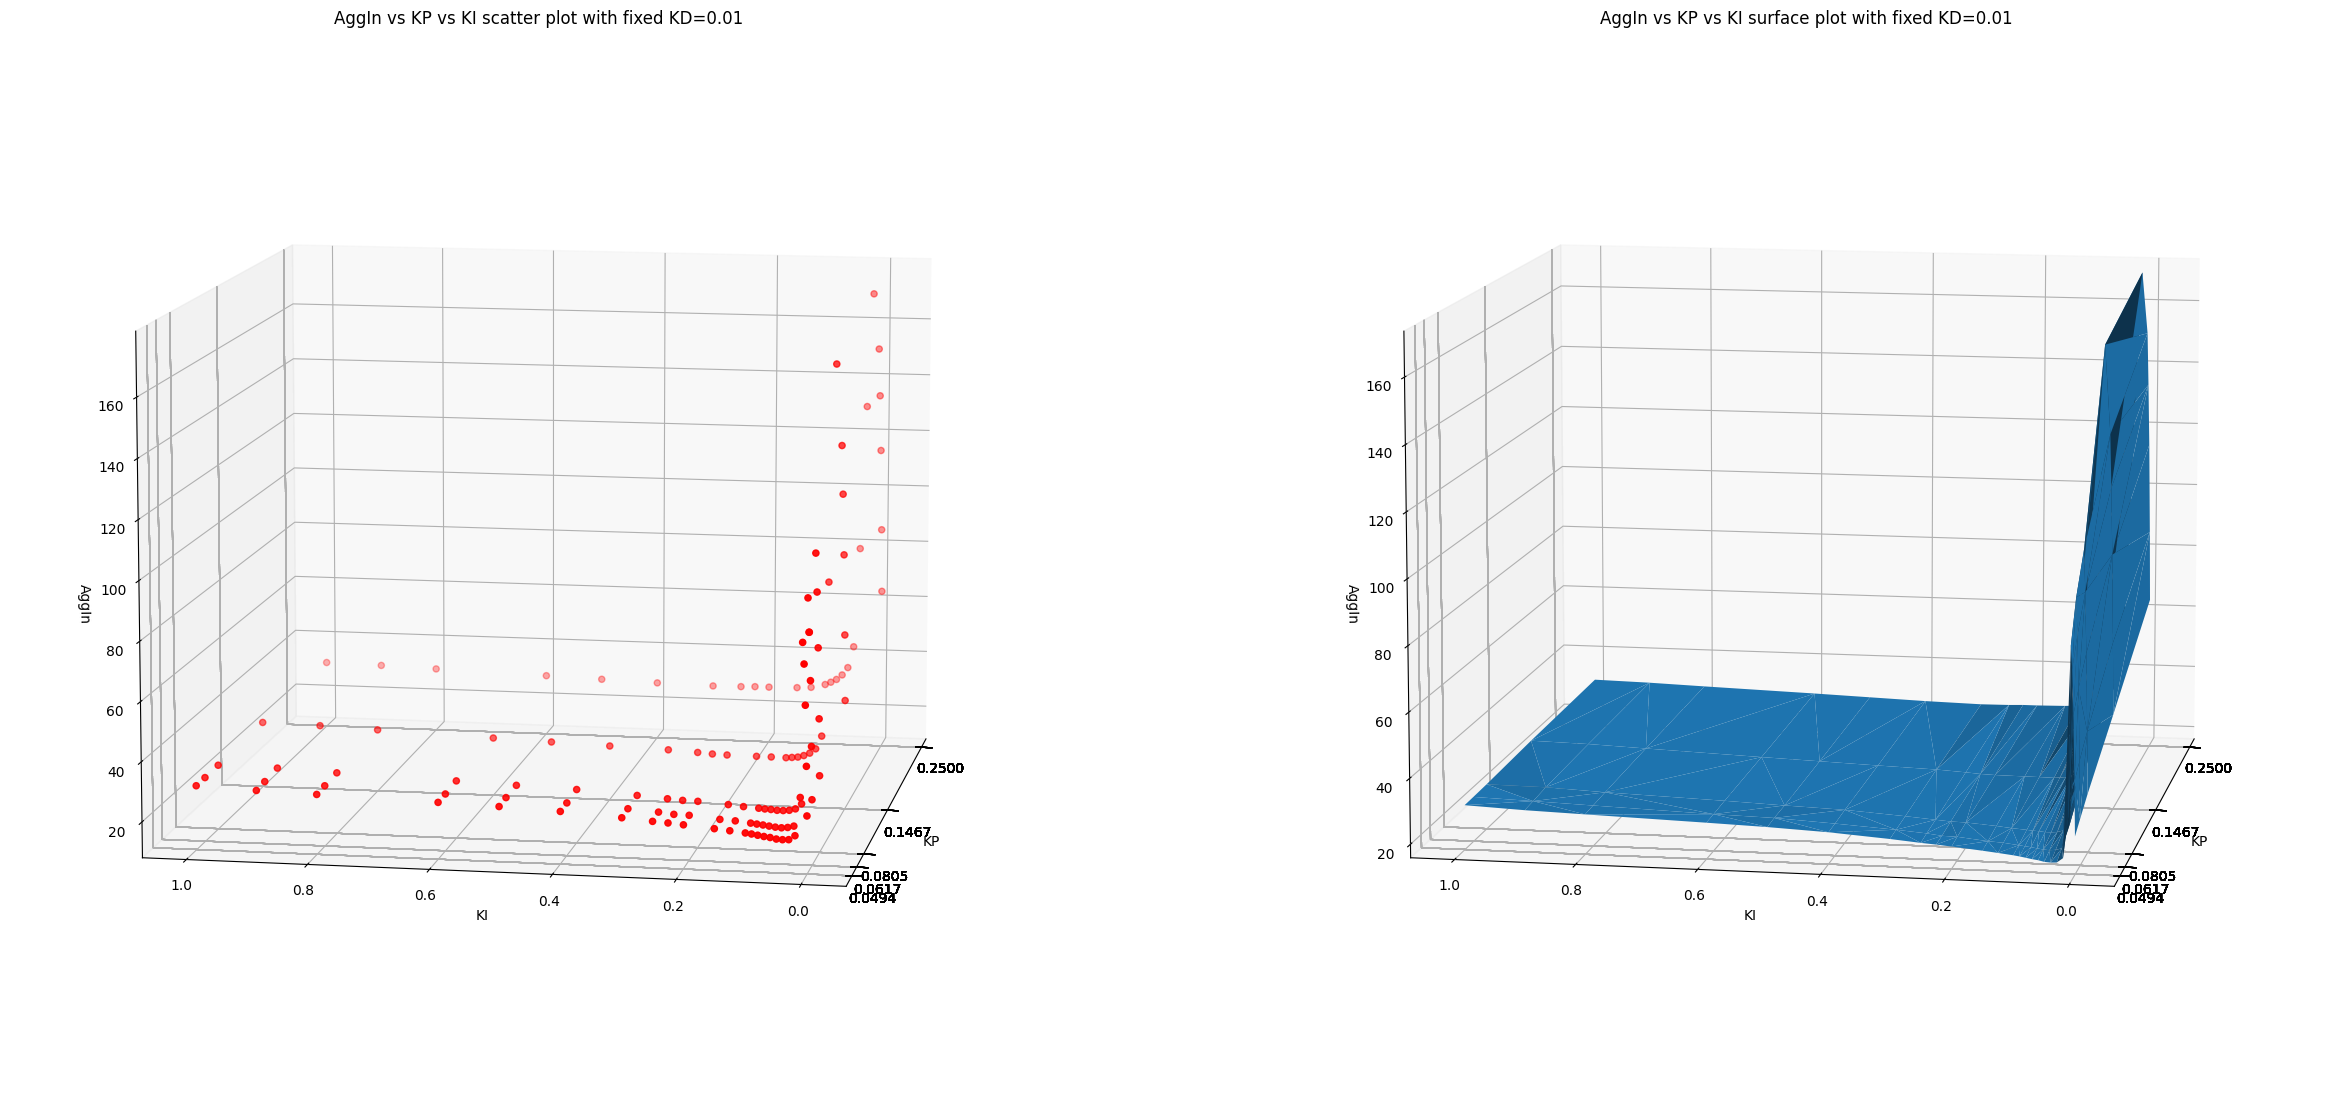

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw=dict(projection='3d'), figsize=(30, 15))
# set title to the first plot and plot the scatter plot
ax1.set_title("AggIn vs KP vs KI scatter plot with fixed KD=0.01")
ax1.scatter([d['KP'] for d in points], [d['KI'] for d in points], [d['AggIn'] for d in points], c='r', marker='o')
ax1.set_xlabel('KP')
# show only the lines corresponding to the values of KP. Ticks are shown, but not the labels
ax1.set_xticks([d['KP'] for d in points])
ax1.set_ylabel('KI')
ax1.set_zlabel('AggIn')
# rotate point of view of 180 degrees around the Z axis
ax1.view_init(azim=190, elev=10)

ax2.set_title("AggIn vs KP vs KI surface plot with fixed KD=0.01")
ax2.plot_trisurf([d['KP'] for d in points], [d['KI'] for d in points], [d['AggIn'] for d in points])
ax2.set_xticks([d['KP'] for d in points])
ax2.set_xlabel('KP')
ax2.set_ylabel('KI')
ax2.set_zlabel('AggIn')
ax2.view_init(azim=190, elev=10)
plt.show()

### Navigable 3D plot

In [14]:
plot_folder = 'Kx_exploration_plots'

##### Scatter plot

In [15]:
# Plot
fig = go.Figure(data=[go.Scatter3d(
    x=[d['KP'] for d in points ],
    y=[d['KI'] for d in points ],
    z=[d['AggIn'] for d in points],
    mode='markers',
    marker=dict(
        size=12,
        color=[d['AggIn'] for d in points],                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)])

fig.update_layout(  title = 'AggIn with fixed KD = 0.01',
                    scene=dict(xaxis_title='KP', yaxis_title='KI', zaxis_title='AggIn',))
fig.write_html(plot_folder + os.sep + 'AggIn_fixedKD_3Dscatter.html')

webbrowser.open(plot_folder + os.sep + 'AggIn_fixedKD_3Dscatter.html',new=2)

True

#### Surface plot

In [16]:
data = go.Surface(x = KIs, y = KPs, z = z)
fig = go.Figure(data = data)
fig.update_layout(  title = 'AggIn with fixed KD = 0.01',
                    scene=dict(xaxis_title='KI', yaxis_title='KP', zaxis_title='AggIn',))
fig.write_html(plot_folder + os.sep + 'AggIn_fixedKD_3Dsurface.html') 

webbrowser.open(plot_folder + os.sep + 'AggIn_fixedKD_3Dsurface.html',new=2)

True

## Fixed $K_d=0.01$ excluding points with big harmonics over a certain threshold

In [17]:
KPs = []
KIs = []
KD = 0.01

f_threshold = 0.8
k_threshold = 0.03

pattern_file = r'PID_([\d\.]+)_([\d\.]+)_([\d\.]+).csv'
pattern_folder = r'KP=([\d\.]+)'

points = []

z = []

for folder in os.listdir('Kx_exploration_data'):
    match_folder = re.match(pattern_folder, folder)
    KP = float(match_folder.group(1))    
    same_KP = []

    for file in os.listdir(os.path.join('Kx_exploration_data', folder)):
        match_file = re.match(pattern_file, file)
        if float(match_file.group(3)) == KD:
            KI = float(match_file.group(2))
                        
            filename = 'Kx_exploration_data' + os.sep + folder + os.sep + file
            signals_df = pd.read_csv(filename, sep=',', header=0)
            x_t = np.array(signals_df['Time'], dtype=float)
            y_rv = np.array(signals_df['Velocity'], dtype=float)
            y_tv = np.array(signals_df['Target Velocity'], dtype=float)
            y_tp = np.array(signals_df['Throttle'], dtype=float)

            x_t = x_t[::k_subsample]
            y_rv = y_rv[::k_subsample]
            y_tv = y_tv[::k_subsample]
            y_tp = y_tp[::k_subsample]
            
            f, Sxx = esd(y_tp, fs_FTP)

            AggIn = float(np.mean(Sxx) / np.std(y_tv - y_rv))

            # append KI and KP value to KIs or KPs list, if the element is not already present
            if KP not in KPs:
                KPs.append(KP)
            if KI not in KIs:
                KIs.append(KI)
  
            
            # append AggIn value to same_KP list only if the spectrum of throttle signal does not contain big harmonics
            # over a certain threshold 
            
            N = len(y_tv)
            yf = fft.rfft(y_tp)
            xf = fft.rfftfreq(N, 1/fs_FTP)
            
            flag = True
            for i in range(int(f_threshold / (fs_FTP / (2 * len(xf)))), len(xf)):
                if  np.abs(yf[i]) * 2 / N > k_threshold:
                    flag = False
                    break
                
            same_KP.append(AggIn)
            points.append({'KP': KP, 'KI' : KI, 'KD': KD, 'AggIn' : AggIn, 'Valid' : flag})
    
    z.append(same_KP)
        

In [18]:
count = 0
for d in points:
    if not d['Valid']:
        count += 1 
print(count, ' invalids over ', len(points))

77  invalids over  130


### Navigable 3D plot

In [19]:
plot_folder = 'Kx_exploration_plots'

##### Scatter plot

In [20]:
# Plot
fig = go.Figure(data=[go.Scatter3d( x=[d['KP'] for d in points ],
                                    y=[d['KI'] for d in points ],
                                    z=[d['AggIn'] if d['Valid'] else None for d in points],
                                    mode='markers',
                                    name = 'valid',
                                    marker=dict(
                                        size=12,
                                        color=[d['AggIn'] for d in points],
                                        colorscale='Viridis',
                                        opacity= 0.8
                                    )),
                      go.Scatter3d( x=[d['KP'] for d in points ],           # invalid points are plotted in red
                                    y=[d['KI'] for d in points ],
                                    z=[d['AggIn'] if not d['Valid'] else None for d in points],
                                    mode='markers',
                                    name = 'invalid',
                                    marker=dict(
                                        size=12,
                                        color='red',
                                        colorscale='Viridis',
                                        opacity= 0.8
                                    ))
                      ])

fig.update_layout(  title = 'AggIn with fixed KD = 0.01 - invalidating harmonics over {} Hz with amplitude bigger than {}'.format(f_threshold, k_threshold),
                    scene=dict(xaxis_title='KP', yaxis_title='KI', zaxis_title='AggIn',))
fig.write_html(plot_folder + os.sep + 'AggIn_fixedKD_3Dscatter_noFastHarmonics.html')

webbrowser.open(plot_folder + os.sep + 'AggIn_fixedKD_3Dscatter_noFastHarmonics.html',new=2)

True